# Optimizing Cython code by writing less Python and more C
We will implement a very simple ray tracing engine. **Ray tracing** consists of rendering a scene by simulating the physical properties of light propagation. This rendering method leads to photorealistic scenes, but it is computationally intensive.

Here, we will render a single sphere and with diffuse and specular lighting. First, we will give the example code in Python, then will accelerate it incrementally with Cython.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
%load_ext Cython

In [11]:
%%cython
import numpy as np

In [2]:
w, h = 400, 400 # Size of the window in pixels

In [3]:
def normalize(x):
    # this function normalizes a vector
    x /= np.linalg.norm(x)
    return x

We declare a NumPy array with `np.ndarray[DBL_C, ndim=1]`. In this example, a 1D array of double precision floating point numbers. There is a difficulty here because NumPy arrays can only be declared in functions, not at the top level. So we need to slightly tweak the overall architecture of the code by passing some arrays as function arguments instead of using global variables.

In the current implementation, we incur a performance hit because of the large number of NumPy function calls on small arrays (three elements). NumPy is designed to deal with large arrays, and it does not make much sense to use it for arrays that small.

In this specific situation, we can try to bypass NumPy by rewriting some functions using the C standard librariy. We use the `cdef` keyword to declare a C-style function. Here we gain a 2-x speed up by replacing the `normalize()` python function with the following C function.

In [16]:
%%cython
import numpy as np
cimport numpy as np
DBL = np.double 
ctypedef np.double_t DBL_C

from libc.math cimport sqrt
cdef normalize(np.ndarray[DBL_C, ndim=1] x):
    cdef double n
    n = sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2])
    x[0] /= n
    x[1] /= n
    x[2] /= n
    return x

To get the most interesting speedups, we need to completely bypass NumPy. We use NumPy at
* Many variables are NumPy arrays (most 1-D vectors with 3 elements)
* Element-wise operations yield implicit NumPy API calls.
* We also use a few NumPy built-in functions such as `numpy.dot()`.

In order to bypass NumPy in our example, we need to reimplement all these features for our specific needs. We are going to define a pure C structure instead of using a Python type for our vectors. In otherwords, we are not only bypassing NumPy, but we are bypassing Python by moving to pure C code. To declare a C structure representing a 3D vector in Cython, we can use the following code:

In [ ]:
%%cython
cdef struct Vec3:
    double x, y, z
    
cdef Vec3 vec3(double x, double y, double z):
    cdef Vec3 v
    v.x = x
    v.y = y
    v.z = z
    return v

cdef Vec3 add(Vec3 u, Vec3 v):
    return vec3(u.x + v.x, u.y + v.y, u.z + v.z)

Now we create a function that computes the intersection of a ray with a sphere:

In [4]:
def intersect_sphere(O, D, S, R):
    """ Return the distance from O to the intersection
    of the ray (O, D) and the sphere (S, R), or
    +inf if there is no intersection.
    O and S are 3D points, D(direction) is a 
    normalized vector, R is a scalar.
    """
    a = np.dot(D, D)
    OS = O - S
    b = 2 * np.dot(D, OS)
    c = np.dot(OS, OS) - R * R
    disc = b*b - 4*a*c
    
    if disc > 0:
        distSqrt = np.sqrt(disc)
        q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
        t0 = q / a
        t1 = c / q
        t0, t1 = min(t0, t1), max(t0, t1)
        if t1 >= 0:
            return t1 if t0 < 0 else t0
    return np.inf

In [5]:
def trace_ray(O, D):
    """Find first point of intersection with the scene."""
    t = intersect_sphere(O, D, position, radius)
    # No intersection?
    if t == np.inf:
        return
    # Find the point of intersection on the object.
    M = O + D * t
    N = normalize(M - position)
    toL = normalize(L - M)
    toO = normalize(O - M)
    # Ambient light
    col = ambient
    # Lambert shading (diffuse)
    col += diffuse * max(np.dot(N, toL), 0) * color
    # Blinn-Phon shading (specular).
    col += specular_c * color_light * max(np.dot(N, normalize(toL + toO)), 0)** specular_k
    return col

In [6]:
def run():
    img = np.zeros((h, w, 3))
    # Loop through all pixels
    for i, x in enumerate(np.linspace(-1, 1, w)):
        for j, y in enumerate(np.linspace(-1, 1, h)):
            # Position of the pixel
            Q[0], Q[1] = x, y
            # Direction of the ray going through
            # the optical center.
            D = normalize(Q - O)
            # Launch the ray and get the color of the pixel.
            col = trace_ray(O, D)
            if col is None:
                continue
            img[h - j - 1, i, :] = np.clip(col, 0, 1)
    return img

In [7]:
# Sphere properties.
position = np.array([0., 0., 1.])
radius = 1
color = np.array([0, 0, 1])
diffuse = 1.
specular_c = 1.
specular_k = 50

# Light position and color
L = np.array([5., 5., -10.])
color_light = np.ones(3)
ambient = 0.05

# camera
O = np.array([0., 0., -1.]) # Position
Q = np.array([0., 0., 0.]) # Pointing to

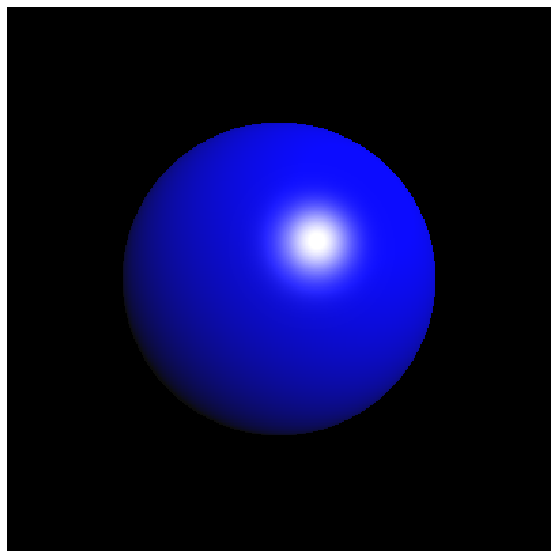

In [8]:
img = run()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.set_axis_off()

In [9]:
%timeit run()

4.89 s ± 597 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
